## VTT Tool not used.  Instead, controller is queried for imon

In [1]:
import sys,os,time #,clr

from pathlib import Path
#import os
import datetime
import openpyxl

In [23]:
import fcns.static_LL_NOTOOL as static_LL
import fcns.file_output as file_output

In [24]:
import pandas as pd

In [25]:
pmbaddr=0x64
#dut: DUT = DUT(pmbaddr)

### Input - Parameters

In [26]:
microproc_family = 'LNL'
power_level      = '17W'
test_rail        = "VCCSA"

#power_states = [1]#,1,2,3]
pstate=0

loadhw = "kikusui"

In [6]:
#power_states[0]

### Testplan filename for output

In [27]:
#family_folder = Path("C:/Users/GKIDWELL/OneDrive - Renesas Electronics Corporation/Productlines/MultiphaseDigital/Owl_GWS_fets/imon_gws_vs_aos")
family_folder = Path('testplan')
#rspec_folder = 'RAA225000_2P1P1_Dell_Arches13MLK_U15_ID0_PN420_050323'
path = family_folder#/rspec_folder
dir_list = os.listdir(path)

In [28]:
dir_list

['A2_RAA225019_VCCSA_644954_IMVP9p2_Volt_Reg_Valid_Plan_Rev1p7.xlsm']

In [29]:
file_idx = 0
testplanfile = path/dir_list[file_idx]
testplanfile

WindowsPath('testplan/A2_RAA225019_VCCSA_644954_IMVP9p2_Volt_Reg_Valid_Plan_Rev1p7.xlsm')

### Extract imon upper and lower limits from testplan

In [30]:
from openpyxl import load_workbook

In [31]:
imon_limits = {"sheet":"IOUT Calcs",
                   "cells":{0 :{"load":"O23:O33",
                                 "lower"  :"R23:R33",
                                 "upper"  :"S23:S33"
                                 },
                            1 :{"load":"O43:O53",
                                 "lower"  :"R43:R53",
                                 "upper"  :"S43:S53"
                                 },
                            2 :{"load":"O64:O67",
                                 "lower"  :"R64:R67",
                                 "upper"  :"S64:S67"
                                 }
                            }
                  }

### Testplan filename for output

In [32]:
wb = load_workbook(testplanfile,data_only=True)
ws = wb[imon_limits["sheet"]]

C:\users\gkidwell\OneDrive - Renesas Electronics Corporation\python\rp2040\u2if_env_hp\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
C:\users\gkidwell\OneDrive - Renesas Electronics Corporation\python\rp2040\u2if_env_hp\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\users\gkidwell\OneDrive - Renesas Electronics Corporation\python\rp2040\u2if_env_hp\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [33]:
limits = {phase:{column:[value[0].value 
                 for value in ws[imon_limits['cells'][phase][column]] if value[0].value != '#N/A']
                 for column in ['load','lower','upper']}
                 for phase in [0,1,2]}
                         

In [34]:
limits

{0: {'load': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22],
  'lower': [1.4, 3.2, 5.22, 7.2, 9, 11.16, 13.02, 15.04, 16.92, 19, 20.9],
  'upper': [2.6, 4.8, 6.78, 8.8, 11, 12.84, 14.98, 16.96, 19.08, 21, 23.1]},
 1: {'load': [2, 3, 4, 5, 6, 7, 8, 9],
  'lower': [0, 1.5, 3.32, 4.25, 5.25, 6.265, 7.24, 8.145],
  'upper': [4, 4.5, 4.68, 5.75, 6.75, 7.735, 8.76, 9.855]},
 2: {'load': [2, 3, 4, 5],
  'lower': [0, 1.5, 3.32, 4.25],
  'upper': [4, 4.5, 4.68, 5.75]}}

In [35]:
df_limits = pd.DataFrame.from_dict(limits[pstate])
df_limits.load=df_limits.load.round(pstate)


In [36]:
df_limits

,load,lower,upper
0,2,1.40,2.60
1,4,3.20,4.80
2,6,5.22,6.78
3,8,7.20,8.80
4,10,9.00,11.00
5,12,11.16,12.84
6,14,13.02,14.98
7,16,15.04,16.96
8,18,16.92,19.08
9,20,19.00,21.00


### Take loadline data

In [58]:
# datasets = {str(pstate):static_LL.setup_and_take_data(microproc_family,power_level,test_rail,pstate,loadhw) 
#            for pstate in power_states}
datasets = static_LL.setup_and_take_data(pmbaddr,microproc_family,power_level,test_rail,pstate,loadhw) 

##################################
----------------------------------
    DC LOAD LINE AT PS = 0    
----------------------------------
##################################

Begining Test


...............................
load	dIMON	IMON	nPHASE
...............................
0.12	0x0	0.0	1
2.104	0xa	1.49	1
4.098	0x17	3.427	2
6.093	0x25	5.514	2
8.081	0x33	7.6	2
10.046	0x3f	9.388	2
12.034	0x4d	11.475	4
14.023	0x5a	13.412	4
16.015	0x68	15.498	4
18.004	0x73	17.137	4
20.029	0x82	19.373	4
22.018	0x8f	21.31	4
-------------------------------

Test complete.


### Create Dataframe from test data

In [59]:
df = pd.DataFrame(datasets)[['load','dimon','imon','nphase']]
df.load=df.load.round(pstate)
df

,load,dimon,imon,nphase
0,0.0,0x0,0.000,1
1,2.0,0xa,1.490,1
2,4.0,0x17,3.427,2
3,6.0,0x25,5.514,2
4,8.0,0x33,7.600,2
5,10.0,0x3f,9.388,2
6,12.0,0x4d,11.475,4
7,14.0,0x5a,13.412,4
8,16.0,0x68,15.498,4
9,18.0,0x73,17.137,4


In [20]:
int('0x4',16)

4

### Combine Testdata and Testlimits into 1 dataframe

In [39]:
#df_loadline = pd.concat([df_limits['current'],df['imon'],df_limits['lower'],df_limits['upper']],axis=1);
df_imon = pd.merge(df,df_limits,how='outer',on=['load']).drop('dimon',axis=1)


In [40]:
df_imon

,load,imon,nphase,lower,upper
0,0.0,0.000,1,NaN,NaN
1,2.0,1.341,1,1.40,2.60
2,4.0,3.427,1,3.20,4.80
3,6.0,5.514,2,5.22,6.78
4,8.0,7.600,2,7.20,8.80
5,10.0,9.537,2,9.00,11.00
6,12.0,11.325,4,11.16,12.84
7,14.0,13.263,4,13.02,14.98
8,16.0,15.200,4,15.04,16.96
9,18.0,17.286,4,16.92,19.08


In [42]:
df_imon['imon']=df_imon['imon']+.75
df_imon

,load,imon,nphase,lower,upper
0,0.0,0.750,1,NaN,NaN
1,2.0,2.091,1,1.40,2.60
2,4.0,4.177,1,3.20,4.80
3,6.0,6.264,2,5.22,6.78
4,8.0,8.350,2,7.20,8.80
5,10.0,10.287,2,9.00,11.00
6,12.0,12.075,4,11.16,12.84
7,14.0,14.013,4,13.02,14.98
8,16.0,15.950,4,15.04,16.96
9,18.0,18.036,4,16.92,19.08


In [20]:
df_all = df_imon.merge(df,how='outer',on=['load']).drop('dimon',axis=1)
#df_1st = df_all[['load','imon_x']];df_1st

### Plot Imon against limits

<AxesSubplot:xlabel='load'>

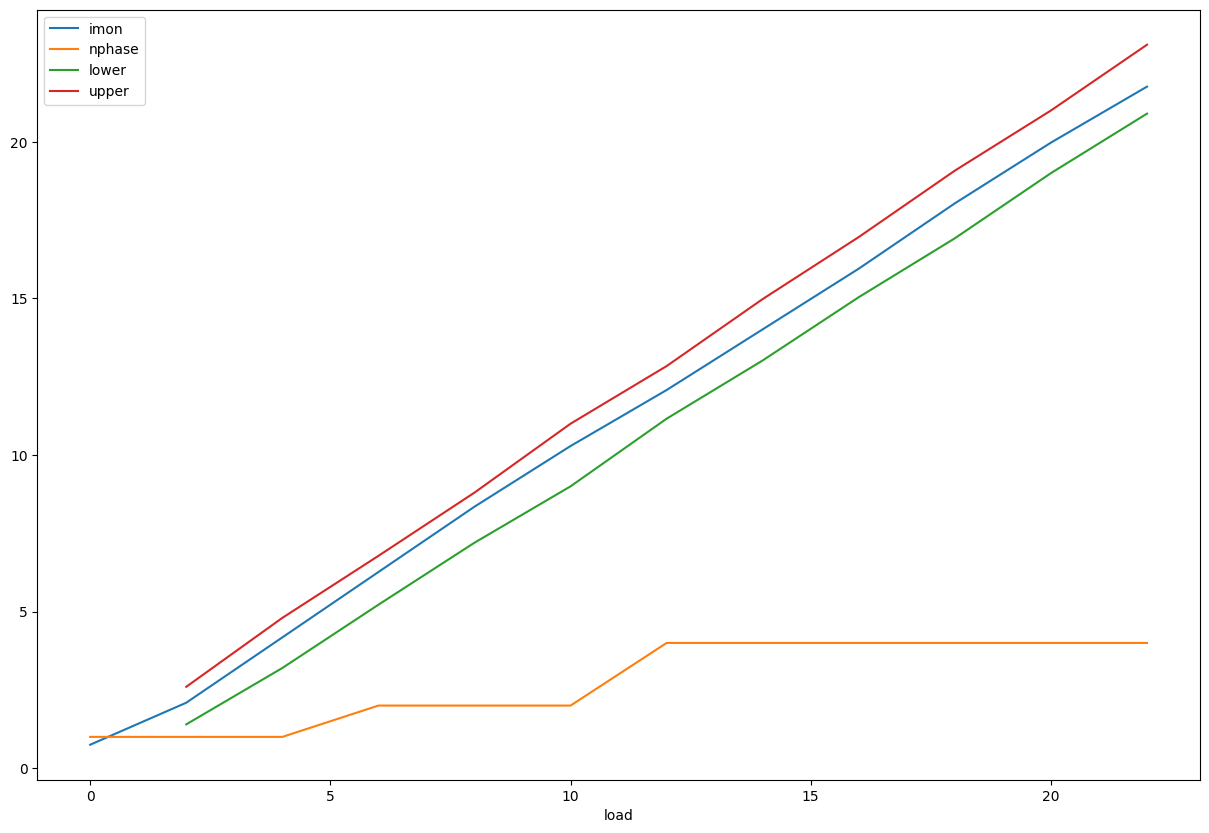

In [43]:
df_imon.plot(x='load',figsize=(15,10))

### Output data to datafile

In [ ]:
datasetname = 'barnowl_15F0_GT2' #'barn_owl_GT1'
#datasetname = 'limits'

In [ ]:
currentdate = datetime.datetime.today().strftime ('_%y%m%d_%H%M%S')
#filename = path/('imon_rawdata_'+currentdate+'.xlsx')
filename = path/('imon_rawdata_134A_1p08_v3.xlsx')
with pd.ExcelWriter(filename, mode = 'a') as writer:
    df.to_excel(writer,sheet_name = datasetname,index=False)
#df.to_excel(filename,index=False)#,sheet_name = datasetname,index=False)

### Output data to intel test plan
Manually open the excel file first and eliminate any dialog boxes before proceeding

In [ ]:
file_output.intel_test_plan(testplanfile,datasets,'1')

In [ ]:
datasets